<a href="https://colab.research.google.com/github/AudePertron/chromosomes/blob/main/chromos_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
cd gdrive/MyDrive/chromos/base_donnees/ChromSeg/region-guided\ UNet++

/content/gdrive/MyDrive/chromos/base_donnees/ChromSeg/region-guided UNet++


In [ ]:
ls

dataset/  loss.py  main.py  model.pth  __pycache__/  UNet_plus.py  utils.py


In [ ]:
#!git clone https://github.com/HKU-BAL/ChromSeg.git

In [ ]:
#!unzip /content/gdrive/MyDrive/chromos/base_donnees/ChromSeg/ChromSeg_dataset.zip -d /content/gdrive/MyDrive/chromos/base_donnees/data &> /dev/null



In [ ]:
#loss.py
import torch
import torch.nn as nn
import torch.nn.functional as F

try:
    from LovaszSoftmax.pytorch.lovasz_losses import lovasz_hinge
except ImportError:
    pass

__all__ = ['BCEDiceLoss', 'LovaszHingeLoss', 'FocalLoss', 'WeightedFocalLoss']

class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input, target):
        bce = F.binary_cross_entropy_with_logits(input, target)
        smooth = 1e-5
        input = torch.sigmoid(input)
        num = target.size(0)
        input = input.view(num, -1)
        target = target.view(num, -1)
        intersection = (input * target)
        dice = (2. * intersection.sum(1) + smooth) / (input.sum(1) + target.sum(1) + smooth)
        dice = 1 - dice.sum() / num
        return 0.5 * bce + dice

class LovaszHingeLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input, target):
        input = input.squeeze(1)
        target = target.squeeze(1)
        loss = lovasz_hinge(input, target, per_image=True)

        return loss

class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.5, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, _input, target):
        pt = torch.sigmoid(_input)
        pt = pt.clamp(min=0.00001,max=0.99999)
        loss = - self.alpha * (1 - pt) ** self.gamma * target * torch.log(pt) - \
            (1 - self.alpha) * pt ** self.gamma * (1 - target) * torch.log(1 - pt)

        if self.reduction == 'mean':
            loss = torch.mean(loss)
        elif self.reduction == 'sum':
            loss = torch.sum(loss)
            
        return loss

class WeightedFocalLoss(nn.Module):
    def __init__(self, gammas=[0, 1], alpha=0.25, reduction='mean'):
        super().__init__()
        self.gammas = gammas
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, _input, target, weight = None):
        pt = torch.sigmoid(_input)
        
        loss = torch.zeros_like(_input)
        for gamma in self.gammas:
            loss += - self.alpha * (1 - pt) ** gamma * target * torch.log(pt) - \
                (1 - self.alpha) * pt ** gamma * (1 - target) * torch.log(1 - pt)
        
        loss /= len(self.gammas)
        
        if weight is None:
            weight = torch.ones_like(_input).to(device)
        
        loss *= weight
        
        if self.reduction == 'mean':
            loss = torch.mean(loss)
        elif self.reduction == 'sum':
            loss = torch.sum(loss)
            
        return loss

In [ ]:
#utils.py

from torchvision.transforms import transforms
import torch.nn.functional as F
from torch.autograd import Variable
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torchvision.transforms import transforms
from torch.utils.data import Dataset
import PIL.Image as Image
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math
import copy

'''
The code to preprocessing and load dataset
'''

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def make_dataset(root):
    imgs=[]
    for filename in os.listdir(root):
        form = filename.split('_')[0]
        if form == 'image':
            tag = filename.split('_')      
            img = os.path.join(root, filename)
            mask1 = os.path.join(root,'binary_label_' + tag[1])
            mask2 = os.path.join(root,'binary_label2_' + tag[1])
            imgs.append((img,mask1,mask2))
    return imgs

class Dataset2(Dataset):
    def __init__(self, root, transform=None, target_transform=None):
        imgs = make_dataset(root)
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        x_path, y1_path, y2_path = self.imgs[index]

        img_x = Image.open(x_path)
        img_y1 = Image.open(y1_path)
        img_y2 = Image.open(y2_path)
        if self.transform is not None:
            img_x = self.transform(img_x)
        if self.target_transform is not None:
            img_y1 = img_y1.convert('L')
            img_y2 = img_y2.convert('L')
            img_y1 = self.target_transform(img_y1)
            img_y2 = self.target_transform(img_y2)
        return img_x, img_y1, img_y2

    def __len__(self):
        return len(self.imgs)

x_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

y_transforms = transforms.Compose([
    transforms.ToTensor()
])

def train_model(model, criterion, optimizer, dataloader_train, dataloader_val, num_epochs=20, patience=30): # use early stop
    min_val_loss = float('inf')
    best_epoch = 0
    best_model = None
    for epoch in range(num_epochs):
        dt_size = len(dataloader_train.dataset)
        # ----------------------TRAIN-----------------------
        model.train()
        epoch_loss = 0
        step = 0
        for x, y, c in dataloader_train:
            step += 1
            inputs = x.to(device)
            labels = y.to(device)
            labels2 = c.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            outputs = model(inputs)
            loss = 0.5 * criterion(outputs[0], labels) + 0.5 * criterion(outputs[1], labels2)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print("%d/%d,train_loss:%0.3f" % (step, (dt_size - 1) // dataloader_train.batch_size + 1, loss.item()))
        print("epoch %d training loss:%0.3f" % (epoch, epoch_loss/step))
        # ----------------------VALIDATION-----------------------
        with torch.no_grad():
            model.eval()
            epoch_loss = 0
            step = 0
            for x, y, c in dataloader_val:
                step += 1
                inputs = x.to(device)
                labels = y.to(device)
                labels2 = c.to(device)
                outputs = model(inputs)
                loss = 0.7 * criterion(outputs[0], labels) + 0.3 * criterion(outputs[1], labels2)
                epoch_loss += loss.item()
            val_loss = epoch_loss/step
            print("epoch %d validation loss:%0.5f" % (epoch, val_loss))
        if val_loss < min_val_loss:
            best_epoch = epoch
            min_val_loss = val_loss
            #torch.save(model.state_dict(), './models/weights-epoch%d-val_loss%s.pth' % (epoch, val_loss))
            best_model = copy.deepcopy(model)
        if epoch - best_epoch > patience:
            break
    print('Best validation loss%0.5f at epoch%s'% (min_val_loss, best_epoch))
    return best_model

def meanIOU_per_image(y_pred, y_true):
    '''
    Calculate the IOU, averaged across images
    '''
    y_pred = y_pred.astype('bool')
    y_true = y_true.astype('bool')
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    
    return np.sum(intersection) / np.sum(union)

class Score():
    def __init__(self, y_pred, y_true, size = 512, threshold = 0.5):
        self.TN = 0
        self.FN = 0
        self.FP = 0
        self.TP = 0
        self.y_pred = y_pred > threshold
        self.y_true = y_true
        self.threshold = threshold
        
        for i in range(0, size):
            for j in range(0, size):
                if self.y_pred[i,j] == 1:
                    if self.y_pred[i,j] == self.y_true[i][j]:
                        self.TP = self.TP + 1
                    else:
                        self.FP = self.FP + 1
                else:
                    if self.y_pred[i,j] == self.y_true[i][j]:
                        self.TN = self.TN + 1
                    else:
                        self.FN = self.FN + 1        
 
    def get_Se(self):
        return (self.TP)/(self.TP + self.FN)
    
    def get_Sp(self):
        return (self.TN)/(self.TN + self.FP)
    
    def get_Pr(self):
        return (self.TP)/(self.TP + self.FP)
    
    def F1(self):
        Pr = self.get_Pr()
        Se = self.get_Se()
        return (2*Pr*Se)/(Pr + Se)
    
    def G(self):
        Sp = self.get_Sp()
        Se = self.get_Se()
        return math.sqrt(Se*Sp)
    
    def IoU(self):
        Pr = self.get_Pr()
        Se = self.get_Se()
        return (Pr*Se) /(Pr + Se - Pr*Se)
    
    def DSC(self):
        return (2* self.TP)/(2* self.TP + self.FP + self.FN) 

In [ ]:
#Unet_plus.py

import torch
from torch import nn
from torchvision.transforms import transforms
import torchvision.models as models

class DoubleConv(nn.Module):
    # The convolutional layer: conv3-relu-conv3-relu
    def __init__(self, in_ch, mid_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, mid_ch, 3, padding=1),
            nn.BatchNorm2d(mid_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)


class UNet_plus2(nn.Module):
    
    def __init__(self, in_ch=3, out_ch=1):
        super(UNet_plus2, self).__init__()
        self.n_channels = in_ch
        self.n_classes = out_ch
        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8]

        # Encoder: U-Net
        #self.conv0_0 = nn.Sequential(
        #    nn.Conv2d(in_ch, filters[0], kernel_size=7, stride=1, padding=3,
        #         bias=False),
        #    nn.BatchNorm2d(filters[0]),
        #    nn.ReLU(inplace=True)
        #)
        self.conv0_0 = DoubleConv(self.n_channels, filters[0], filters[0])
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, ceil_mode=True)
        self.conv1_0= DoubleConv(filters[0], filters[1], filters[1])
        self.conv2_0= DoubleConv(filters[1], filters[2], filters[2])
        self.conv3_0= DoubleConv(filters[2], filters[3], filters[3])

        # Upsample layer(Deconv)
        self.up1_0 = nn.ConvTranspose2d(filters[1], filters[0], 2, stride=2)
        self.up2_0 = nn.ConvTranspose2d(filters[2], filters[1], 2, stride=2)
        self.up3_0 = nn.ConvTranspose2d(filters[3], filters[2], 2, stride=2)
        self.up1_1 = nn.ConvTranspose2d(filters[1], filters[0], 2, stride=2)
        self.up2_1 = nn.ConvTranspose2d(filters[2], filters[1], 2, stride=2)
        self.up1_2 = nn.ConvTranspose2d(filters[1], filters[0], 2, stride=2)

        # Mid Layer
        self.conv0_1 = DoubleConv(filters[0]*2, filters[0], filters[0]) 
        self.conv1_1 = DoubleConv(filters[1]*2, filters[1], filters[1])
        self.conv2_1 = DoubleConv(filters[2]*2, filters[2], filters[2])

        self.conv0_2 = DoubleConv(filters[0]*2, filters[0], filters[0])
        self.conv1_2 = DoubleConv(filters[1]*2, filters[1], filters[1])

        self.conv0_3 = DoubleConv(filters[0]*2, filters[0], filters[0])

        # attention
        # self.attention0 = ContourAttention(filters[0])
        # self.attention1 = ContourAttention(filters[1])
        
        self.contour = nn.Sequential(
            nn.Conv2d(filters[0] * 2, filters[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(filters[0], filters[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(filters[0], out_ch, 1)
        )
        self.final = nn.Sequential(
            nn.Conv2d(filters[0], filters[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(filters[0], out_ch, 1)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x0_0 = self.conv0_0(x)
        p = self.pool(x0_0)
        x1_0 = self.conv1_0(p)
        x2_0 = self.conv2_0(self.pool(x1_0))
        x3_0 = self.conv3_0(self.pool(x2_0))

        x0_1 = self.conv0_1(torch.cat([x0_0, self.up1_0(x1_0)], 1)) + x0_0
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up2_0(x2_0)], 1))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up3_0(x3_0)], 1))
        
        x0_2 = self.conv0_2(torch.cat([x0_1, self.up1_1(x1_1)], 1)) + x0_1
        # x1_2 = self.conv1_2(torch.cat([self.attention1(x1_1, x1_0), self.up2_1(x2_1)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, self.up2_1(x2_1)], 1))
        
        # x0_3 = self.conv0_3(torch.cat([self.attention0(x0_2, x0_0), self.up1_2(x1_2)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, self.up1_2(x1_2)], 1))
        
        contour = self.contour(torch.cat([x0_1, x0_2], dim=1))
        output = self.final(x0_3)

        return self.sigmoid(output), self.sigmoid(contour)

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7060113071745259719, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11345264640
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1816299314727320445
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [ ]:
#main.py

import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torchvision.transforms import transforms
from torch.utils.data import Dataset
import torchvision.models as models
import PIL.Image as Image
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import copy
#from loss import *
#from UNet_plus import UNet_plus2 as UNet_plus2
#from utils import *
import argparse
import sys

if __name__ == '__main__':

    IMAGE_SIZE = 256
    batch_size = 8
    
    torch.manual_seed(0)    # reproducible
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("device : ", device)
    model = UNet_plus2(3, 1)
    model = model.to(device)


    gamma=1
    alpha=0.75
    criterion = FocalLoss(gamma, alpha, reduction='mean')
    optimizer = optim.Adam(model.parameters())
    dataset_train = Dataset2('dataset/train', transform=x_transforms, target_transform=y_transforms)
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
    dataset_val = Dataset2('dataset/val', transform=x_transforms, target_transform=y_transforms)
    dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True, num_workers=0)
    
    model = train_model(model, criterion, optimizer, dataloader_train, dataloader_val, num_epochs=100, patience=7)
    
    model = model.cpu()
    dataloader_val = DataLoader(dataset_val, batch_size=1, shuffle=True, num_workers=0)

    iou = 0
    iou2 = 0
    n = 0
    model.eval()
    with torch.no_grad():
        for x, target, c in dataloader_val:
            n = n + 1
            y = model(x)
            y_pred_0 = torch.squeeze(y[0]).numpy()
            y_pred = np.zeros((256,256))
            y_pred[y_pred_0 > 0.5] = 1.0
            y_2_0 = torch.squeeze(y[1]).numpy()
            y_2 = np.zeros((256,256))
            y_2[y_2_0 > 0.5] = 1.0
            y_true = torch.squeeze(target).numpy()
            y_true2 = torch.squeeze(c).numpy()
            output1 = np.reshape(y_pred * 255,(256,256))
            output2 = np.reshape(y_2 * 255,(256,256))

            x_image = torch.squeeze(x).numpy()
            image = np.dstack((x_image[0,...]*255, x_image[1,...]*255, x_image[2,...]*255))

            cv2.imwrite('output1/' + str(n) + ".png", output1)
            cv2.imwrite('output2/' + str(n) + ".png", output2)
            cv2.imwrite('img/' + str(n) + ".png", image)
            try:
                iou += meanIOU_per_image(y_pred, y_true)
                iou2 += meanIOU_per_image(y_2, y_true2)
            except Exception as e:
                print(e)
                print('y_pred: %s'% y_pred)
                print('y_true: %s'% y_true)
                torch.save(model.state_dict(), './models/%s_seed%s_error.pth' % ('caché', 'coucou'))
                sys.exit(0)
    IoU = float(iou/n)
    IoU2 = float(iou2/n)
    
    print('Final_IoU: %s'% IoU)
    print('Final_IoU2: %s'% IoU2)
    torch.save(model.state_dict(), 'model.pth')

device :  cuda


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


1/32,train_loss:0.154
2/32,train_loss:0.144
3/32,train_loss:0.141
4/32,train_loss:0.137
5/32,train_loss:0.132
6/32,train_loss:0.132
7/32,train_loss:0.128
8/32,train_loss:0.126
9/32,train_loss:0.124
10/32,train_loss:0.121
11/32,train_loss:0.120
12/32,train_loss:0.119
13/32,train_loss:0.119
14/32,train_loss:0.117
15/32,train_loss:0.117
16/32,train_loss:0.116
17/32,train_loss:0.116
18/32,train_loss:0.115
19/32,train_loss:0.114
20/32,train_loss:0.114
21/32,train_loss:0.113
22/32,train_loss:0.112
23/32,train_loss:0.112
24/32,train_loss:0.111
25/32,train_loss:0.111
26/32,train_loss:0.111
27/32,train_loss:0.110
28/32,train_loss:0.110
29/32,train_loss:0.109
30/32,train_loss:0.109
31/32,train_loss:0.109
32/32,train_loss:0.108
epoch 0 training loss:0.120
epoch 0 validation loss:0.10722
1/32,train_loss:0.108
2/32,train_loss:0.108
3/32,train_loss:0.107
4/32,train_loss:0.107
5/32,train_loss:0.107
6/32,train_loss:0.106
7/32,train_loss:0.106
8/32,train_loss:0.106
9/32,train_loss:0.105
10/32,train_los

In [ ]:
#model = model = UNet_plus2(3, 1)
#model.load_state_dict(torch.load('/content/gdrive/MyDrive/chromos/base_donnees/ChromSeg/region-guided UNet++/model.pth'))
model.eval()

UNet_plus2(
  (conv0_0): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv1_0): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)


In [ ]:
image = Image.open('/content/gdrive/MyDrive/chromos/base_donnees/ChromSeg/crossing-partition/img/2.png')

x_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

image_test = x_transforms(image)

In [ ]:
pred_test = model(image_test[None, ...])

In [ ]:
n = 0
with torch.no_grad():
  y = model(image_test[None, ...])
  y_pred_0 = torch.squeeze(y[0]).numpy()
  y_pred = np.zeros((256,256))
  y_pred[y_pred_0 > 0.5] = 1.0
  y_2_0 = torch.squeeze(y[1]).numpy()
  y_2 = np.zeros((256,256))
  y_2[y_2_0 > 0.5] = 1.0
  output1 = np.reshape(y_pred * 255,(256,256))
  output2 = np.reshape(y_2 * 255,(256,256))

  x_image = torch.squeeze(image_test).numpy()
  image = np.dstack((x_image[0,...]*255, x_image[1,...]*255, x_image[2,...]*255))

  cv2.imwrite('/content/gdrive/MyDrive/chromos/base_donnees/outputs/output1/' + str(n) + ".png", output1)
  cv2.imwrite('/content/gdrive/MyDrive/chromos/base_donnees/outputs/output2/' + str(n) + ".png", output2)
  cv2.imwrite('/content/gdrive/MyDrive/chromos/base_donnees/outputs/images/' + str(n) + ".png", image)

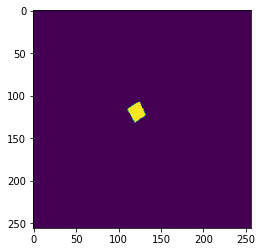

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(output1)

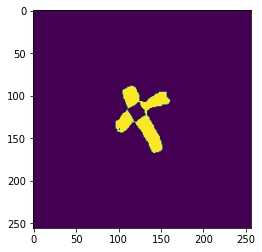

In [ ]:
plt.imshow(output2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


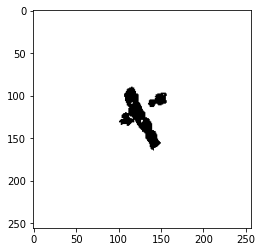

In [ ]:
plt.imshow(image)